# Purpose


### 2023-04-25
In this notebook we'll try an end-to-end process to get user<>subreddit table & training datay for a single campaign.

#### Changes & hypothesis to test in this iteration:
- How does scaling features improve robustness?

#### Changes to test in next iteration:
- Install & test new models (sklearn's `HistGradientBoostingClassifier`, XGBoost, LightGBM)
    - XGboost is a good OG
    - LightGBM does a good job with categorical variables
    - `HistGradientBoostingClassifier` is a LightGBM clone inside of sklearn
    
- Features: Replace ANN distance metrics with ToSubreddit percent
    - ANN distance is time & compute expensive (1st we need to get weighted embeddings, 2nd get ANN distance)
    - Can we replace with ToSubreddit 
- Features: iteration v2
    - Target subreddit
        - add percent of users L28 for top countries
    - User:
        - engagement cohort
        - frequency cohort
    - user <> subreddit (already pre-computed in feature store)
        - target sub: visit ratio N-days (14, 30)
            - how many days did a user visit the subreddit?
            - E.g., 14 days: Percent of last 14 days that user visited the subreddit
                - E.g., 1/14 = 0.0714 => 1 day in last 14 days
            - ** Need to "explode" this one in BQ because it's also encoded in same way as ToSub
        - 3 nearest subs to target sub: visit ratio N-days (14, 30)
            - same as target sub, but calculate it over 3 ANNs to target sub. Aggregate by SUM() or MEAN()
    - user <> subreddit (did these come from the PN model from ML?)
        - user_subreddit_trending_pn_clicked_l7
        - user_subreddit_trending_pn_clicked_l14
        - user_subreddit_trending_pn_received_l14
        - user_subreddit_trending_pn_received_l7
        - Days on subreddit (L7, L28) (this feature is a repeats info from visit ratio, so may not be needed)


---

**DONE (previous steps/notebooks)**
- Pull data:
    - User Time on Subreddit (save to local now, GCS in prod)
    - Get subreddit-level embeddings (save to local, GCS in prod)
- Reshape to get user-embeddings
    - For each ToSub file, get weighted embeddings for a user
        - Save user-level (weighted) embeddings to file
- Calculate ANN distance to input subreddit(s)
    - Create an index with ANNOY: per COUNTRY + subreddit
        - This way we ensure a minimum # of users per country
    - Load subreddit-embedding file
    - For each input target subreddit, get the ANN users
        - Try nearest 3 million users
    - Save raw ANN file

- Change scoring metrics suffix from `weighted` (e.g., `f1_weighted` -> `f1_macro`, `f1`)
    - Why? Because `weighted` gives too much value to the majority class (no clicks) and we care more about the minority class (click)
    - `macro` (both positive & negative) 
    - and `empty`/null (only report the positive class)
- Does stratifying on other important columns help at train/test split?


**This notebook:** <br>
(Quick version of these steps. We'll re-write when scaling up to multiple campaigns b/c the data will prob change)
- Load training data & labels for modeling (click/no click)
- Split into basic train/test fold
- Train base models on labeled data
    - Quick evaluation of model


**TODO later / out of scope**
<br> Do these steps once we have models that do well enough to actually score over 100 subreddits.
- Run inference on all users & get proba() for all users & user<>sub combination
    - Save proba raw file
- Rank users by proba
    - Compare which users our model would say likely to click, but didn't even receive the PN
- Reshape user<>subreddit proba PN for bigQuery
    - Pick top 1 million users per subreddit

- Split training file into k-fold validation or train/test
- Train base models (do it a separate notebook)
- [later/tbd] Reshape ANN table & upload to BQ table
    - Reshape ANN file for BigQuery format
    - Upload ANN file to BQ for table creation




# Imports & Setup

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from datetime import datetime
import gc
import logging
from logging import info
import os
from pathlib import Path
import json

import polars as pl
import numpy as np
import pandas as pd
import plotly
import seaborn as sns

from tqdm.auto import tqdm
import dask
import mlflow

import subclu
from subclu.eda.aggregates import compare_raw_v_weighted_language
from subclu.utils import set_working_directory, get_project_subfolder
from subclu.utils.eda import (
    setup_logging, counts_describe, value_counts_and_pcts,
    notebook_display_config, print_lib_versions,
    style_df_numeric, reorder_array,
)
from subclu.utils.mlflow_logger import MlflowLogger
from subclu.utils.hydra_config_loader import LoadHydraConfig
from subclu.utils.data_irl_style import (
    get_colormap, theme_dirl, 
    get_color_dict, base_colors_for_manual_labels,
    check_colors_used,
)
from subclu.data.data_loaders import LoadPosts, LoadSubreddits, create_sub_level_aggregates


# ===
# imports specific to this notebook
from typing import Tuple, Union

from subclu.models.nn_annoy import AnnoyIndex
from subclu.utils.eda import get_venn_sets2

from matplotlib_venn import venn2_unweighted

from google.cloud import bigquery
from subclu.pn_models import get_data


client = bigquery.Client()

print_lib_versions([bigquery, np, pd, pl, plotly, mlflow, subclu])

python		v 3.7.10
===
google.cloud.bigquery	v: 2.13.1
numpy		v: 1.19.5
pandas		v: 1.2.4
polars		v: 0.17.1
plotly		v: 5.11.0
mlflow		v: 1.16.0
subclu		v: 0.6.1


In [3]:
# plotting
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib.dates as mdates
plt.style.use('default')

setup_logging()
notebook_display_config()

# Define local path for this model outputs

In [4]:
manual_model_timestamp = datetime.utcnow().strftime('%Y-%m-%d_%H%M%S')
path_this_model = get_project_subfolder(
    f"data/models/pn_model/pn_manual_test_{manual_model_timestamp}"
)
Path.mkdir(path_this_model, parents=True, exist_ok=True)
print(path_this_model)

/home/jupyter/subreddit_clustering_i18n/data/models/pn_model/pn_manual_test_2023-04-26_051651


In [5]:
path_ann_df = Path("/home/jupyter/subreddit_clustering_i18n/data/models/pn_model/pn_manual_test_2023-04-19_172950")
f_ann_df = str(path_ann_df / "df_ann_distance_to_target-10533999_5.parquet")

In [6]:
!ls $path_ann_df

df_ann_distance_to_target-10533999_5.parquet
df_ann_distance_to_target-10533999_6.parquet
df_subreddit_embeddings_wide-236115_102.parquet
df_user_embedding-2023-04-19_1841-10533999_by_101.parquet


# Define key inputs
Use these throughout the process to filter/target specific subreddits, geos, & users

In [7]:
l_target_subreddits = ['de']

# We would want to add an automated way to pick these ANN subs, but look them up manually for now
l_target_ann_subreddits = ['fragreddit', 'ich_iel']

l_target_geos = ['DE']

# Load & reshape data

## Load training data from BQ

Label info:
- send, receive, click [Click is the target, but we need sends & receives so that we can select only users who received or clicked]

Selected features v0:
- TODO: num of subreddits in ToS calculation
- views, consumes, etc. in target subreddit
- User latest country
- user<>subreddit distances (currently in a local file, not in BQ)

features to add for v1:
- target subreddit percentage visits from different geos (wide version of `community_score` table)
- target subreddit primary language
- user primary language(s)

#### Features to add maybe way later(?)
`Subscription` tables expire after 90 days... (sigh)
<br>So we'll have imperfect data for training models before 2023-02
<br>Maybe we should just exclude it for historical campaigns and only add it going forward?


**NOTE / TODO(djb)**
- For this notebook I'll only train on user who RECEIVED the PN
- But in the future we might want to model whether someone will even receive the PN (saves us from wasting PNs on users not likely to be active... unless the goal is to re-activate dormant users)

In [8]:
%%time
%%bigquery df_train_raw --project data-science-prod-218515 

-- Select trainig data AND users to train PN model
DECLARE PT_FEATURES DATE DEFAULT "2022-12-01";
DECLARE PT_WINDOW_START DATE DEFAULT PT_FEATURES - 7;

WITH subreddit_per_user_count AS (
    SELECT
        tos.user_id
        , COUNT(DISTINCT subreddit_id) AS tos_sub_count
    FROM `reddit-employee-datasets.david_bermejo.pn_test_users_de_campaign_tos_30_pct_20230418` AS tos
    GROUP BY 1
)
, post_consumes_agg AS (
    SELECT
        user_id
        , SUM(num_post_consumes) AS num_post_consumes
        , SUM(num_post_consumes_home) AS num_post_consumes_home
        , SUM(num_post_consumes_community) AS num_post_consumes_community
        , SUM(num_post_consumes_post_detail) AS num_post_consumes_post_detail
        , SUM(IF(app_name = 'ios', num_post_consumes, 0)) AS num_post_consumes_ios
        , SUM(IF(app_name = 'android', num_post_consumes, 0)) AS num_post_consumes_android
        , SUM(num_post_consumes_nsfw) AS num_post_consumes_nsfw
        , SAFE_DIVIDE(SUM(num_post_consumes_nsfw), SUM(num_post_consumes)) AS pct_post_consumes_nsfw
        -- , SUM(num_post_consumes_sfw) AS num_post_consumes_sfw
    FROM `data-prod-165221.video.post_consumes_30d_agg`
    WHERE DATE(pt) = PT_FEATURES
    GROUP BY 1
)
, core_train_info AS (
    SELECT
        -- Need to fill cases where user_id is missing from new selection criteria
        COALESCE(act.user_id, f.user_id) AS user_id
        , COALESCE(act.target_subreddit, f.subreddit_name) AS subreddit_name
        , COALESCE(act.send, 0) AS send
        , COALESCE(act.receive, 0) AS receive
        , COALESCE(act.click, 0) AS click
        
        -- , f.subreddit_id
        -- , f.subreddit_name AS view_sub_name
        , f.* EXCEPT(pt, pt_window_start, user_id, subreddit_name, subreddit_id)

    FROM (
        SELECT *
        FROM `reddit-employee-datasets.david_bermejo.pn_test_users_de_campaign_20230418`
        WHERE subreddit_name = 'de'
    ) AS f
        FULL OUTER JOIN `reddit-employee-datasets.david_bermejo.pn_training_data_test` AS act
            ON f.user_id = act.user_id
)
, user_actions_t7 AS (
    SELECT
      pne.user_id,
      COUNT(receive_endpoint_timestamp) user_receives_pn_t7,
      COUNT(click_endpoint_timestamp) user_clicks_pn_t7,
      COUNT(
        CASE
          WHEN notification_type='lifecycle_post_suggestions' 
            THEN click_endpoint_timestamp
          ELSE NULL
        END
    ) user_clicks_trnd_t7
    FROM `data-prod-165221.channels.push_notification_events` AS pne
    INNER JOIN core_train_info AS c
        ON pne.user_id = c.user_id
    WHERE
        DATE(pt) BETWEEN PT_WINDOW_START AND PT_FEATURES
        AND NOT REGEXP_CONTAINS(notification_type, "email")
        AND receive_endpoint_timestamp IS NOT NULL
  GROUP BY user_id 
)

SELECT
    -- Need to fill cases where user_id is missing from new selection criteria
    ct.user_id
    , ct.subreddit_name
    , ct.send
    , ct.receive
    , ct.click
    , COALESCE(tos.tos_sub_count, 0) AS tos_sub_count
    , COALESCE(sv.feature_value, 0) AS screen_view_count_14d
    , COALESCE(cl.legacy_user_cohort, '_missing_') AS legacy_user_cohort
    , pna.* EXCEPT(user_id)
    , co.* EXCEPT(user_id)
    , ct.* EXCEPT(user_id, subreddit_name, send, receive, click)

FROM core_train_info AS ct
    -- Get count of subs in ToS
    LEFT JOIN subreddit_per_user_count AS tos
        ON ct.user_id = tos.user_id
    -- Recent PN activity 
    LEFT JOIN user_actions_t7 AS pna
        ON ct.user_id = pna.user_id
    -- Get view counts (all subreddits)
    LEFT JOIN (
        SELECT entity_id, feature_value
        FROM `data-prod-165221.user_feature_platform.screen_views_count_over_14_days_v1` 
        WHERE DATE(pt) = PT_FEATURES
    ) AS sv
        ON ct.user_id = sv.entity_id
    -- USER cohort, Legacy
    LEFT JOIN (
        SELECT user_id, legacy_user_cohort
        FROM `data-prod-165221.attributes_platform.user_rolling_legacy_user_cohorts` 
        WHERE DATE(pt) = PT_FEATURES
    ) AS cl
        ON ct.user_id = cl.user_id
    -- USER consumes
    LEFT JOIN post_consumes_agg AS co
        ON ct.user_id = co.user_id

WHERE ct.receive = 1

-- ORDER BY click DESC, tos_sub_count DESC
;

Downloading: 100%|██████████| 253584/253584 [00:01<00:00, 145279.68rows/s]

CPU times: user 600 ms, sys: 202 ms, total: 803 ms
Wall time: 32.8 s


In [9]:
# df_train_raw.info()

In [10]:
counts_describe(df_train_raw[['user_id', 'subreddit_name',  'click', 'subscribed']])

,dtype,count,unique,unique-percent,null-count,null-percent
user_id,object,"253,584","253,583",100.00%,0,0.00%
subreddit_name,object,"253,584",1,0.00%,0,0.00%
click,int64,"253,584",2,0.00%,0,0.00%
subscribed,float64,"181,406",1,0.00%,"72,178",28.46%


Unclear where these duplicates came from, but for now we'll remove them.

TODO(djb): Will go back to debug user-generation later

In [11]:
(
    df_train_raw[df_train_raw.duplicated(subset='user_id', keep=False)]
    .sort_values(by=['user_id'])
)

,user_id,subreddit_name,send,receive,click,tos_sub_count,screen_view_count_14d,legacy_user_cohort,user_receives_pn_t7,user_clicks_pn_t7,user_clicks_trnd_t7,num_post_consumes,num_post_consumes_home,num_post_consumes_community,num_post_consumes_post_detail,num_post_consumes_ios,num_post_consumes_android,num_post_consumes_nsfw,pct_post_consumes_nsfw,geo_country_code,subscribed,user_in_actual_but_missing_from_new,view_and_consume_unique_count,consume_unique_count,view_count,consume_count,consume_ios_count,consume_android_count
51484,t2_6yxrzyy,de,1,1,0,121,21,core,208.0,4.0,4.0,8806.0,1351.0,3198.0,0.0,8806.0,0.0,185.0,0.021008,DE,0.0,0.0,744.0,742.0,380.0,2216.0,2216.0,0.0
186274,t2_6yxrzyy,de,1,1,0,121,21,core,208.0,4.0,4.0,8806.0,1351.0,3198.0,0.0,8806.0,0.0,185.0,0.021008,DE,0.0,0.0,1.0,1.0,0.0,2.0,2.0,0.0


In [12]:
%%time

df_train_raw = df_train_raw.drop_duplicates(subset=['user_id'], keep=False)
df_train_raw.shape

CPU times: user 113 ms, sys: 19.9 ms, total: 133 ms
Wall time: 132 ms


(253582, 28)

In [13]:
counts_describe(df_train_raw[['user_id', 'subreddit_name', 'click', 'subscribed']])

,dtype,count,unique,unique-percent,null-count,null-percent
user_id,object,"253,582","253,582",100.00%,0,0.00%
subreddit_name,object,"253,582",1,0.00%,0,0.00%
click,int64,"253,582",2,0.00%,0,0.00%
subscribed,float64,"181,404",1,0.00%,"72,178",28.46%


In [14]:
assert len(df_train_raw) == df_train_raw['user_id'].nunique()

In [15]:
df_train_raw.head()

,user_id,subreddit_name,send,receive,click,tos_sub_count,screen_view_count_14d,legacy_user_cohort,user_receives_pn_t7,user_clicks_pn_t7,user_clicks_trnd_t7,num_post_consumes,num_post_consumes_home,num_post_consumes_community,num_post_consumes_post_detail,num_post_consumes_ios,num_post_consumes_android,num_post_consumes_nsfw,pct_post_consumes_nsfw,geo_country_code,subscribed,user_in_actual_but_missing_from_new,view_and_consume_unique_count,consume_unique_count,view_count,consume_count,consume_ios_count,consume_android_count
0,t2_152xqd,de,1,1,0,83,21,core,64.0,1.0,1.0,23490.0,15631.0,3511.0,0.0,0.0,23490.0,1241.0,0.052831,DE,0.0,0.0,35.0,35.0,6.0,82.0,0.0,82.0
1,t2_2zz577fw,de,1,1,0,131,21,core,1.0,0.0,0.0,6151.0,2018.0,3109.0,0.0,0.0,6151.0,666.0,0.108275,DE,0.0,0.0,71.0,70.0,104.0,282.0,0.0,282.0
2,t2_5hxipiuk,de,1,1,0,240,21,core,83.0,0.0,0.0,13158.0,9196.0,1145.0,0.0,0.0,13158.0,983.0,0.074707,EG,0.0,0.0,82.0,82.0,58.0,212.0,0.0,212.0
3,t2_7wccd2ar,de,1,1,0,317,21,core,38.0,0.0,0.0,14802.0,628.0,5761.0,0.0,0.0,14802.0,4856.0,0.328064,DE,0.0,0.0,1134.0,1132.0,584.0,4594.0,0.0,4594.0
4,t2_t3r9i,de,1,1,1,58,21,core,NaN,NaN,NaN,11121.0,3377.0,3812.0,0.0,0.0,10480.0,314.0,0.028235,DE,0.0,0.0,1036.0,1036.0,112.0,2984.0,0.0,2430.0


## Append user<>subreddit distances 

In [16]:
%%time

df_ann = pl.read_parquet(
    f_ann_df,
    columns=['subreddit_name', 'user_id', 'cosine_similarity'],
)
df_ann.shape

CPU times: user 530 ms, sys: 196 ms, total: 727 ms
Wall time: 367 ms


(10533999, 3)

In [17]:
(
    df_ann
    .sample(n=int(1e6))
    [['cosine_similarity']]
    .describe()
)

describe,cosine_similarity
str,f64
"""count""",1e6
"""null_count""",0.0
"""mean""",0.454675
"""std""",0.189968
"""min""",-0.034057
"""max""",1.0
"""median""",0.436443


In [18]:
%%time

df_train = (
    df_train_raw
    # .drop(['subreddit_id', 'view_sub_name', ], axis=1)
    [df_train_raw['receive'] == 1]
    .merge(
        df_ann.to_pandas(),
        how='left',
        on=['user_id', 'subreddit_name'],
    ) 
)

df_train.shape

CPU times: user 13.7 s, sys: 1.32 s, total: 15 s
Wall time: 15 s


(253582, 29)

# Some EDA

In [19]:
counts_describe(df_train)

,dtype,count,unique,unique-percent,null-count,null-percent
user_id,object,"253,582","253,582",100.00%,0,0.00%
subreddit_name,object,"253,582",1,0.00%,0,0.00%
send,int64,"253,582",1,0.00%,0,0.00%
receive,int64,"253,582",1,0.00%,0,0.00%
click,int64,"253,582",2,0.00%,0,0.00%
tos_sub_count,int64,"253,582",816,0.32%,0,0.00%
screen_view_count_14d,int64,"253,582",21,0.01%,0,0.00%
legacy_user_cohort,object,"253,582",5,0.00%,0,0.00%
user_receives_pn_t7,float64,"247,591",903,0.36%,"5,991",2.36%
user_clicks_pn_t7,float64,"247,591",240,0.10%,"5,991",2.36%


### All users in original campaign are in new data selection

However, this is only because I forced them into the new selection. It's possible they had views over 1 month ago OR no views at all (if the selection was based on subscription).

In [20]:
value_counts_and_pcts(
    df_train['user_in_actual_but_missing_from_new'].fillna(-1),
    sort_index=True,
    top_n=None,
)

,user_in_actual_but_missing_from_new-count,user_in_actual_but_missing_from_new-percent,user_in_actual_but_missing_from_new-pct_cumulative_sum
0.0,"181,404",71.5%,71.5%
-1.0,"72,178",28.5%,100.0%


### Click (CTR)
Since we're looking only at user that RECEIVED the PN, this CTR should be the same as the one computed in the overall dashboard

In [21]:
value_counts_and_pcts(
    df_train,
    ['click'],
    sort_index=True,
    top_n=None,
)

,count,percent,cumulative_percent
click,,,
1,"13,226",5.2%,5.2%
0,"240,356",94.8%,100.0%


### Clicks by Geo

In [22]:
df_geo_receive_counts = (
    df_train
    .groupby(['geo_country_code'], as_index=False)
    .agg(
        **{'receive_count': ('receive', 'count')}
    )
)

df_geos_over_200 = (
    df_geo_receive_counts
    [df_geo_receive_counts['receive_count'] >= 200]  
)
display(df_geos_over_200)

df_click_by_geo = value_counts_and_pcts(
    df_train,
    ['geo_country_code', 'click'],
    sort_index=True,
    sort_index_ascending=True,
    reset_index=True,
    top_n=None,
    return_df=True
)


style_df_numeric(
    df_click_by_geo
    [(
        (df_click_by_geo['geo_country_code'].isin(df_geos_over_200['geo_country_code'])) |
        (df_click_by_geo['geo_country_code'] == 'null')
    )]
    .drop('cumulative_percent', axis=1)
    .set_index(['geo_country_code', 'click'])
    ,
    l_bar_simple=['count', 'percent'],
)


,geo_country_code,receive_count
4,AT,850
20,CH,633
29,DE,174807
37,ES,245
41,FR,240
42,GB,478
93,NL,564
127,US,653


### Clicks - cohorts

In [23]:
l_imporant_cat_cols = [
    'legacy_user_cohort',
    
]

for c_ in l_imporant_cat_cols:
    print(f"\n== {c_} ==")
    display(
        value_counts_and_pcts(
            (
                df_train
                # we're now doing the FILLNA in SQL, so we shouldn't need to fill in python
                # .assign(legacy_user_cohort=df_train['legacy_user_cohort'].fillna('_missing_pd_'))
            ),
            [c_, 'click'],
            sort_index=True,
            top_n=None,
        )
    )
    display(
        value_counts_and_pcts(
            (
                df_train
                # we're now doing the FILLNA in SQL, so we shouldn't need to fill in python
                # .assign(legacy_user_cohort=df_train['legacy_user_cohort'].fillna('_missing_pd_'))
                [df_train['click'] == 1]
            ),
            [c_, 'click'],
            sort_index=True,
            top_n=None,
        )
    )


== legacy_user_cohort ==


,,count,percent,cumulative_percent
legacy_user_cohort,click,,,
resurrected,1,69,0.5%,0.5%
new,1,17,0.1%,0.7%
core,1,"11,767",89.0%,89.6%
casual,1,244,1.8%,91.5%
_missing_,1,"1,129",8.5%,100.0%


### Clicks - other cuts

In [24]:
q_bins = 5

l_important_num_cols = [
    'user_clicks_pn_t7',
    'user_clicks_trnd_t7',
    'user_receives_pn_t7',
    'screen_view_count_14d',
    'num_post_consumes_home',
    'cosine_similarity',
    'pct_post_consumes_nsfw',
    'num_post_consumes',
    'tos_sub_count',
    'consume_ios_count',
    'consume_android_count',
]
l_cols_to_bin_ = l_important_num_cols
# [
#     'tos_sub_count', 'screen_view_count_14d',
#     'user_receives_pn_t7', 'user_clicks_pn_t7', 'user_clicks_trnd_t7',
    
#     'num_post_consumes', 'num_post_consumes_community',
#     'pct_post_consumes_nsfw',
    
#     'view_and_consume_unique_count',
#     'cosine_similarity'
# ]
pctiles_ = [0.25, 0.333, 0.5, 0.6667, 0.75]
for c_to_bin_ in l_cols_to_bin_:
    c_new_ = f"{c_to_bin_}_bin"
    print(f"\n== {c_to_bin_} ==")
    fill_na_val = -2
    null_count_ = df_train[c_to_bin_].isnull().sum()
    display(style_df_numeric(df_train[c_to_bin_].describe(percentiles=pctiles_).to_frame().T))
    
    if null_count_ > 1:
        # min_val_ = min([fill_na_val, df_train[c_to_bin_].min()])
        display(style_df_numeric(df_train[c_to_bin_].fillna(fill_na_val).describe(percentiles=pctiles_).to_frame().T))
    else:
        # min_val_ = df_train[c_to_bin_].min()
        pass
    

    # Try to make better bins... ?
#     max_val_ = df_train[c_to_bin_].max()
        
#     if min_val_ < 0:
#         bins_ = 
#     else:
#         bins_ = 
    
    display(
        value_counts_and_pcts(
            (
                df_train
                .assign(
                    **{
                        c_new_: pd.qcut(
                            df_train[c_to_bin_].fillna(fill_na_val),
                            q=q_bins,
                            duplicates='drop',
                        )
                    }
                )
                [df_train['click'] == 1]
            ),
            [c_new_, 'click'],
            sort_index=True,
            top_n=None,
            pct_digits=3,
        )
    )



== user_clicks_pn_t7 ==


,count,mean,std,min,25%,33.3%,50%,66.7%,75%,max
user_clicks_pn_t7,"247,591",3.59,11.61,0.00,0.00,0.00,0.00,1.00,3.00,"2,008.00"


,count,mean,std,min,25%,33.3%,50%,66.7%,75%,max
user_clicks_pn_t7,"253,582",3.46,11.51,-2.00,0.00,0.00,0.00,1.00,3.00,"2,008.00"


,,count,percent,cumulative_percent
user_clicks_pn_t7_bin,click,,,
"(4.0, 2008.0]",1,"9,087",68.706%,68.706%
"(1.0, 4.0]",1,"1,675",12.664%,81.370%
"(0.0, 1.0]",1,883,6.676%,88.046%
"(-2.001, 0.0]",1,"1,581",11.954%,100.000%



== user_clicks_trnd_t7 ==


,count,mean,std,min,25%,33.3%,50%,66.7%,75%,max
user_clicks_trnd_t7,"247,591",2.34,5.03,0.00,0.00,0.00,0.00,1.00,2.00,53.00


,count,mean,std,min,25%,33.3%,50%,66.7%,75%,max
user_clicks_trnd_t7,"253,582",2.24,5.01,-2.00,0.00,0.00,0.00,1.00,2.00,53.00


,,count,percent,cumulative_percent
user_clicks_trnd_t7_bin,click,,,
"(3.0, 53.0]",1,"8,084",61.122%,61.122%
"(0.0, 3.0]",1,"1,571",11.878%,73.000%
"(-2.001, 0.0]",1,"3,571",27.000%,100.000%



== user_receives_pn_t7 ==


,count,mean,std,min,25%,33.3%,50%,66.7%,75%,max
user_receives_pn_t7,"247,591",46.76,74.30,1.00,31.00,32.00,33.00,39.00,56.00,"9,137.00"


,count,mean,std,min,25%,33.3%,50%,66.7%,75%,max
user_receives_pn_t7,"253,582",45.61,73.79,-2.00,31.00,32.00,33.00,38.00,54.00,"9,137.00"


,,count,percent,cumulative_percent
user_receives_pn_t7_bin,click,,,
"(64.0, 9137.0]",1,"3,649",27.590%,27.590%
"(34.0, 64.0]",1,"2,993",22.630%,50.219%
"(32.0, 34.0]",1,"1,387",10.487%,60.706%
"(30.0, 32.0]",1,"1,984",15.001%,75.707%
"(-2.001, 30.0]",1,"3,213",24.293%,100.000%



== screen_view_count_14d ==


,count,mean,std,min,25%,33.3%,50%,66.7%,75%,max
screen_view_count_14d,"253,582",14.02,7.70,0.00,7.00,11.00,18.00,21.00,21.00,21.00


,,count,percent,cumulative_percent
screen_view_count_14d_bin,click,,,
"(20.0, 21.0]",1,"8,495",64.230%,64.230%
"(14.0, 20.0]",1,"3,249",24.565%,88.795%
"(5.0, 14.0]",1,"1,173",8.869%,97.664%
"(-0.001, 5.0]",1,309,2.336%,100.000%



== num_post_consumes_home ==


,count,mean,std,min,25%,33.3%,50%,66.7%,75%,max
num_post_consumes_home,"247,440","3,338.75","5,498.51",0.00,40.00,126.00,772.00,"2,762.00","4,496.00","120,607.00"


,count,mean,std,min,25%,33.3%,50%,66.7%,75%,max
num_post_consumes_home,"253,582","3,257.84","5,455.74",-2.00,30.00,102.00,686.00,"2,618.00","4,345.75","120,607.00"


,,count,percent,cumulative_percent
num_post_consumes_home_bin,click,,,
"(5722.8, 120607.0]",1,"4,101",31.007%,31.007%
"(1632.0, 5722.8]",1,"3,660",27.673%,58.680%
"(234.0, 1632.0]",1,"2,935",22.191%,80.871%
"(12.0, 234.0]",1,"1,737",13.133%,94.004%
"(-2.001, 12.0]",1,793,5.996%,100.000%



== cosine_similarity ==


,count,mean,std,min,25%,33.3%,50%,66.7%,75%,max
cosine_similarity,"236,728",0.53,0.22,-0.04,0.37,0.42,0.50,0.61,0.69,1.00


,count,mean,std,min,25%,33.3%,50%,66.7%,75%,max
cosine_similarity,"253,582",0.37,0.67,-2.00,0.33,0.39,0.48,0.59,0.67,1.00


,,count,percent,cumulative_percent
cosine_similarity_bin,click,,,
"(0.742, 1.0]",1,"4,078",30.833%,30.833%
"(0.536, 0.742]",1,"3,011",22.766%,53.599%
"(0.428, 0.536]",1,"2,937",22.206%,75.805%
"(0.292, 0.428]",1,"2,452",18.539%,94.344%
"(-2.001, 0.292]",1,748,5.656%,100.000%



== pct_post_consumes_nsfw ==


,count,mean,std,min,25%,33.3%,50%,66.7%,75%,max
pct_post_consumes_nsfw,"235,441",0.26,0.31,0.00,0.02,0.04,0.08,0.25,0.46,1.00


,count,mean,std,min,25%,33.3%,50%,66.7%,75%,max
pct_post_consumes_nsfw,"253,582",0.09,0.66,-2.00,0.02,0.03,0.07,0.20,0.40,1.00


,,count,percent,cumulative_percent
pct_post_consumes_nsfw_bin,click,,,
"(0.561, 1.0]",1,"1,101",8.325%,8.325%
"(0.123, 0.561]",1,"2,984",22.562%,30.886%
"(0.0406, 0.123]",1,"3,711",28.058%,58.945%
"(0.00651, 0.0406]",1,"3,895",29.450%,88.394%
"(-2.001, 0.00651]",1,"1,535",11.606%,100.000%



== num_post_consumes ==


,count,mean,std,min,25%,33.3%,50%,66.7%,75%,max
num_post_consumes,"247,440","5,607.43","7,790.86",0.00,317.00,730.00,"2,423.00","5,627.00","8,026.00","159,591.00"


,count,mean,std,min,25%,33.3%,50%,66.7%,75%,max
num_post_consumes,"253,582","5,471.56","7,744.10",-2.00,252.00,631.00,"2,251.00","5,415.00","7,819.00","159,591.00"


,,count,percent,cumulative_percent
num_post_consumes_bin,click,,,
"(9695.0, 159591.0]",1,"3,892",29.427%,29.427%
"(3932.0, 9695.0]",1,"3,490",26.387%,55.814%
"(1130.0, 3932.0]",1,"2,882",21.790%,77.605%
"(123.0, 1130.0]",1,"2,026",15.318%,92.923%
"(-2.001, 123.0]",1,936,7.077%,100.000%



== tos_sub_count ==


,count,mean,std,min,25%,33.3%,50%,66.7%,75%,max
tos_sub_count,"253,582",67.63,81.36,0.00,10.00,19.00,41.00,73.00,96.00,"1,469.00"


,,count,percent,cumulative_percent
tos_sub_count_bin,click,,,
"(114.0, 1469.0]",1,"3,283",24.822%,24.822%
"(58.0, 114.0]",1,"3,404",25.737%,50.560%
"(27.0, 58.0]",1,"3,193",24.142%,74.701%
"(7.0, 27.0]",1,"2,395",18.108%,92.810%
"(-0.001, 7.0]",1,951,7.190%,100.000%



== consume_ios_count ==


,count,mean,std,min,25%,33.3%,50%,66.7%,75%,max
consume_ios_count,"181,404",49.68,311.96,0.00,0.00,0.00,0.00,0.00,0.00,"21,548.00"


,count,mean,std,min,25%,33.3%,50%,66.7%,75%,max
consume_ios_count,"253,582",34.97,264.88,-2.00,-2.00,0.00,0.00,0.00,0.00,"21,548.00"


,,count,percent,cumulative_percent
consume_ios_count_bin,click,,,
"(0.0, 21548.0]",1,"1,852",14.003%,14.003%
"(-2.001, 0.0]",1,"11,374",85.997%,100.000%



== consume_android_count ==


,count,mean,std,min,25%,33.3%,50%,66.7%,75%,max
consume_android_count,"181,404",189.01,659.95,0.00,0.00,1.00,6.00,28.00,64.00,"23,748.00"


,count,mean,std,min,25%,33.3%,50%,66.7%,75%,max
consume_android_count,"253,582",134.64,564.79,-2.00,-2.00,0.00,0.00,8.00,24.00,"23,748.00"


,,count,percent,cumulative_percent
consume_android_count_bin,click,,,
"(46.0, 23748.0]",1,"3,922",29.654%,29.654%
"(4.0, 46.0]",1,"2,744",20.747%,50.401%
"(0.0, 4.0]",1,"1,479",11.183%,61.583%
"(-2.001, 0.0]",1,"5,081",38.417%,100.000%


### Subscribed

These all appear "not subscribed" because the retention time is 90 days for this table, so we don't know... sigh

In [25]:
value_counts_and_pcts(
    df_train['subscribed'].fillna(-1),
    sort_index=True,
    top_n=None,
)

,subscribed-count,subscribed-percent,subscribed-pct_cumulative_sum
0.0,"181,404",71.5%,71.5%
-1.0,"72,178",28.5%,100.0%


# Make new columns for stratification

There is too broad a difference for some key columns. If we split train/test randomly, it's possible that we won't get a similar enough distribution in the train & test splits.

In [26]:
l_strat_cat_cols = ['legacy_user_cohort']

In [27]:
remove_new_bin_cols = False
l_strat_bin_cols = list()
fill_na_val_ = -1
pctiles_ = [0.25, 0.333, 0.5, 0.6667, 0.75, 0.8, 0.85]

d_cols_stratify_bins = {
    'user_clicks_pn_t7': [
        -np.inf, fill_na_val_,
        0,
        # 1,
        df_train['user_clicks_pn_t7'].quantile(q=0.75),
        np.inf
    ],
    'num_post_consumes_home': [  # .35 & .75 were too fine grained
        -np.inf, fill_na_val_,
        0,
        # df_train['num_post_consumes_home'].quantile(q=0.35),
        df_train['num_post_consumes_home'].quantile(q=0.55),
        np.inf
    ],
    
    # NSFW % is not as influential and results in too many small groups for stratification
#     'pct_post_consumes_nsfw': [  # .35 & .75 were too fine grained (couldn't stratify b/c too few members in a group)
#         -np.inf, fill_na_val_,
#         0,
#         df_train['pct_post_consumes_nsfw'].quantile(q=0.51),
#         np.inf
#     ],
    
    # Exclude these b/c they duplicate some data from other cols & stratification groups become too small
    # 'user_receives_pn_t7': [
    #     -np.inf, fill_na_val_,
    #     0,
    #     1,
    #     df_train['user_receives_pn_t7'].quantile(q=0.75),
    #     np.inf
    # ],
    # 'screen_view_count_14d': [
    #     -np.inf, fill_na_val_,
    #     0,
    #     df_train['screen_view_count_14d'].quantile(q=0.25),
    #     df_train['screen_view_count_14d'].quantile(q=0.50),
    #     np.inf
    # ],
}

for c_to_bin_, bins_ in d_cols_stratify_bins.items():
    c_new_ = f"{c_to_bin_}_bin"
    print(f"\n== {c_to_bin_} ==")
    l_strat_bin_cols.append(c_new_)
    null_count_ = df_train[c_to_bin_].isnull().sum()
    display(style_df_numeric(df_train[c_to_bin_].describe(percentiles=pctiles_).to_frame().T))
    
    if null_count_ > 1:
        # min_val_ = min([fill_na_val, df_train[c_to_bin_].min()])
        display(style_df_numeric(df_train[c_to_bin_].fillna(fill_na_val_).describe(percentiles=pctiles_).to_frame().T))
    else:
        # min_val_ = df_train[c_to_bin_].min()
        pass
    
    if len(bins_) > 0:
        # If we want to save them: convert to string and then to category 
        #  Because arrow throws errors when trying to save tuple values
        df_train[c_new_] = pd.cut(
            df_train[c_to_bin_].fillna(fill_na_val_),
            bins=bins_,
        )  # .astype(str).astype('category')
        display(
            value_counts_and_pcts(
                df_train,
                [c_new_],
                sort_index=True,
                top_n=None,
                pct_digits=3,
            ).set_caption(f"Total Distribution")
        )
        display(
            value_counts_and_pcts(
                df_train[df_train['click'] == 1],
                [c_new_, 'click'],
                sort_index=True,
                top_n=None,
                pct_digits=3,
            ).set_caption(f"Distribution of Clicks")
        )
        if remove_new_bin_cols:
            df_train = df_train.drop(c_new_, axis=1)

l_strat_bin_cols


== user_clicks_pn_t7 ==


,count,mean,std,min,25%,33.3%,50%,66.7%,75%,80%,85%,max
user_clicks_pn_t7,"247,591",3.59,11.61,0.00,0.00,0.00,0.00,1.00,3.00,5.00,7.00,"2,008.00"


,count,mean,std,min,25%,33.3%,50%,66.7%,75%,80%,85%,max
user_clicks_pn_t7,"253,582",3.49,11.50,-1.00,0.00,0.00,0.00,1.00,3.00,4.00,7.00,"2,008.00"


,count,percent,cumulative_percent
user_clicks_pn_t7_bin,,,
"(3.0, inf]","57,139",22.533%,22.533%
"(0.0, 3.0]","46,094",18.177%,40.710%
"(-1.0, 0.0]","144,358",56.928%,97.637%
"(-inf, -1.0]","5,991",2.363%,100.000%


,,count,percent,cumulative_percent
user_clicks_pn_t7_bin,click,,,
"(3.0, inf]",1,"9,615",72.698%,72.698%
"(0.0, 3.0]",1,"2,030",15.349%,88.046%
"(-1.0, 0.0]",1,"1,098",8.302%,96.348%
"(-inf, -1.0]",1,483,3.652%,100.000%



== num_post_consumes_home ==


,count,mean,std,min,25%,33.3%,50%,66.7%,75%,80%,85%,max
num_post_consumes_home,"247,440","3,338.75","5,498.51",0.00,40.00,126.00,772.00,"2,762.00","4,496.00","5,876.00","7,658.15","120,607.00"


,count,mean,std,min,25%,33.3%,50%,66.7%,75%,80%,85%,max
num_post_consumes_home,"253,582","3,257.86","5,455.73",-1.00,30.00,102.00,686.00,"2,618.00","4,345.75","5,722.80","7,505.00","120,607.00"


,count,percent,cumulative_percent
num_post_consumes_home_bin,,,
"(1188.0, inf]","111,335",43.905%,43.905%
"(0.0, 1188.0]","112,265",44.272%,88.177%
"(-1.0, 0.0]","23,840",9.401%,97.578%
"(-inf, -1.0]","6,142",2.422%,100.000%


,,count,percent,cumulative_percent
num_post_consumes_home_bin,click,,,
"(1188.0, inf]",1,"8,425",63.700%,63.700%
"(0.0, 1188.0]",1,"4,463",33.744%,97.444%
"(-1.0, 0.0]",1,328,2.480%,99.924%
"(-inf, -1.0]",1,10,0.076%,100.000%


['user_clicks_pn_t7_bin', 'num_post_consumes_home_bin']

In [31]:
def create_stratify_col(
    df: pd.DataFrame,
    cols: list,
    strat_col: str = 'stratify_col',
    small_group_val: str = 'other',
) -> pd.Series:
    """Create a concatenated categorical column by combining the input columns
    This helps us replace categories with 1 item with a string so that we avoid errors
    of having only 1 item in a group
    """
    info(f"Get counts of stratified groups...")
    df_stratify_val_counts = value_counts_and_pcts(
        df,
        cols,
        top_n=None,
        return_df=True,
        reset_index=True
    )
    df_stratify_val_counts[strat_col] = (
        df_stratify_val_counts[cols[0]].astype(str)
        .str.cat(
            df_stratify_val_counts[cols[1:]].astype(str), sep="_"
        )
    ).astype('category')

    s_cats_to_group = (
        df_stratify_val_counts[df_stratify_val_counts['count'] <= 1]
        [strat_col]
    )
    info(f"{len(s_cats_to_group):04,.0f} <- Stratify Groups to Roll Up")

    info(f"Create stratified column with raw values")
    s_out = (
        df[cols[0]].astype(str)
        .str.cat(
            df[cols[1:]].astype(str), sep="_"
        )
    )
    s_out.name = strat_col

    # Change to category at the end, AFTER we append the 'other' roll up
    info(f"Replace values of orphan groups")
    s_out = pd.Series(
        np.where(
            s_out.isin(s_cats_to_group),
            small_group_val,
            s_out
        )
    ).astype('category')
    return s_out

In [32]:
%%time
col_stratify_ = 'stratify_col'
df_train[col_stratify_] = create_stratify_col(
    df=df_train,
    cols=['click'] + l_strat_cat_cols + l_strat_bin_cols,
    small_group_val='other',
)

05:18:25 | INFO | "Get counts of stratified groups..."
05:18:25 | INFO | "0,004 <- Stratify Groups to Roll Up"
05:18:26 | INFO | "Create stratified column with raw values"
05:18:26 | INFO | "Replace values of orphan groups"


CPU times: user 504 ms, sys: 63 ms, total: 567 ms
Wall time: 562 ms


In [33]:
counts_describe(df_train[[col_stratify_]])

,dtype,count,unique,unique-percent,null-count,null-percent
stratify_col,category,"253,582",106,0.04%,0,0.00%


In [34]:
# value_counts_and_pcts(
#     df_train['stratify_col'],
#     top_n=None,
# )

# Save train data so it's easier to jump straight into modeling
This way we can re-use the same train & test data & compare models on other runs

NOTE: for some reason the binned columns create errors when saving to parquet. If you want to save them, conver to string first and then to category. For now I'm dropping them.

In [35]:
path_this_model

PosixPath('/home/jupyter/subreddit_clustering_i18n/data/models/pn_model/pn_manual_test_2023-04-26_051651')

In [36]:
l_strat_bin_cols

['user_clicks_pn_t7_bin', 'num_post_consumes_home_bin']

In [37]:
# %%time

# r_, c_ = df_train.drop(l_strat_bin_cols, axis=1).shape
# df_train.drop(l_strat_bin_cols, axis=1).to_parquet(
#     path_this_model / f"df_train-{r_}_{c_}.parquet"
# )
# del r_, c_

In [38]:
!ls $path_this_model

In [39]:
!du -Lsh $path_this_model/* | sort -hr 

du: cannot access '/home/jupyter/subreddit_clustering_i18n/data/models/pn_model/pn_manual_test_2023-04-26_051651/*': No such file or directory


# Split into train data & run CV folds

In [95]:
from sklearn.compose import ColumnTransformer

from sklearn.preprocessing import OneHotEncoder, RobustScaler, StandardScaler
from sklearn.model_selection import train_test_split


from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold 

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
# from sklearn.ensemble import HistGradientBoostingClassifier  # need to update sklearn to get LGBM-like model

In [46]:
l_train_cols_cat = [
    # 'geo_country_code',
    'legacy_user_cohort',
]

l_train_cols_num = [
    # user-only columns
    'tos_sub_count',
    'user_receives_pn_t7',
    'user_clicks_pn_t7',
    'user_clicks_trnd_t7',
    # 'subscribed',  # Subscribed data doesn't exist for dates older than 90 days ://
    
    'screen_view_count_14d',
    'num_post_consumes',
    'num_post_consumes_home',
    'num_post_consumes_community',
    'num_post_consumes_post_detail',
    'num_post_consumes_ios',
    'num_post_consumes_android',
    'num_post_consumes_nsfw',
    'pct_post_consumes_nsfw',
    
    # user<> subreddit cols
    'view_and_consume_unique_count',
    'consume_unique_count',
    'view_count',
    'consume_count',
    'consume_ios_count',
    'consume_android_count',
    'cosine_similarity'
]
# For some features we want to flag nulls as negative to distinguish data missing
#  instead of filling as zeros
l_col_fill_neg = [
    'tos_sub_count',
    'user_receives_pn_t7',
    'user_clicks_pn_t7',
    'user_clicks_trnd_t7',
    
    'screen_view_count_14d',
    'num_post_consumes',
    'num_post_consumes_home',
    'num_post_consumes_community',
    'num_post_consumes_post_detail',
    'num_post_consumes_ios',
    'num_post_consumes_android',
    'num_post_consumes_nsfw',
    'pct_post_consumes_nsfw',
]
d_fillna_ = {c: -1 for c in l_col_fill_neg}
for c_ in l_train_cols_num:
    if c_ not in l_col_fill_neg:
        d_fillna_[c_] = 0


y = df_train['click']

X = (
    # simple strategy for nulls
    # use column transformer to handle category cols
    df_train[l_train_cols_cat + l_train_cols_num].fillna(d_fillna_).copy()
    # use
#     .merge(
#         pd.get_dummies(df_train['legacy_user_cohort'].fillna('_missing_'), prefix='legacy_user_cohort'),
#         how='left',
#         left_index=True,
#         right_index=True,
#     )
)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=df_train[col_stratify_],
)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(202865, 21)
(202865,)
(50717, 21)
(50717,)


In [47]:
# xgboost needs label encoder (numeric) instead of strings
# https://stackoverflow.com/questions/71996617/invalid-classes-inferred-from-unique-values-of-y-expected-0-1-2-3-4-5-got

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_train_le = le.fit_transform(y_train)

In [48]:
value_counts_and_pcts(y_train)

,click-count,click-percent,click-pct_cumulative_sum
0,"192,284",94.8%,94.8%
1,"10,581",5.2%,100.0%


In [49]:
value_counts_and_pcts(y_test)

,click-count,click-percent,click-pct_cumulative_sum
0,"48,072",94.8%,94.8%
1,"2,645",5.2%,100.0%


In [192]:
counts_describe(X_train)

,dtype,count,unique,unique-percent,null-count,null-percent
legacy_user_cohort,object,"202,865",5,0.00%,0,0.00%
tos_sub_count,int64,"202,865",783,0.39%,0,0.00%
user_receives_pn_t7,float64,"202,865",823,0.41%,0,0.00%
user_clicks_pn_t7,float64,"202,865",222,0.11%,0,0.00%
user_clicks_trnd_t7,float64,"202,865",52,0.03%,0,0.00%
screen_view_count_14d,int64,"202,865",21,0.01%,0,0.00%
num_post_consumes,float64,"202,865","27,602",13.61%,0,0.00%
num_post_consumes_home,float64,"202,865","21,175",10.44%,0,0.00%
num_post_consumes_community,float64,"202,865","10,029",4.94%,0,0.00%
num_post_consumes_post_detail,float64,"202,865",496,0.24%,0,0.00%


In [193]:
%%time
n_cv_splits = 4
cv = StratifiedKFold(n_splits=n_cv_splits, shuffle=True, random_state=42)


# l_onehot_trans_ = [('onehot', OneHotEncoder(), c_) for c_ in l_train_cols_cat]
# del l_onehot_trans_

preprocessor_ = ColumnTransformer(
    transformers=[
        ('onehot', OneHotEncoder(), l_train_cols_cat),
        ('scale', RobustScaler(), l_train_cols_num),
    ],
    remainder='passthrough',
)
d_models_and_params = {
    'rf_pre': {
        # use class_weight='balanced' to give more weight to minority class
        'pipe': Pipeline(
            [
                ('preprocess', preprocessor_),
                ('clf', RandomForestClassifier(
                    n_jobs=-1, random_state=42, class_weight='balanced'
                )),
            ]
        ),
        'params': {
            'preprocess__scale': [RobustScaler(), ],  # l_train_cols_cat
            'clf__n_estimators': [800],
            'clf__criterion': ['gini',],  # ['gini', 'log_loss', 'entropy']
            'clf__max_depth': [30],  # 50 too big. small (shallow) => regularize model
            'clf__min_samples_leaf': [2],  # 2 or 3. bigger => add more regularization
        }
    },
    'rf': {
        # use class_weight='balanced' to give more weight to minority class
        'pipe': Pipeline(
            [
                ('preprocess', ColumnTransformer(
                        transformers=[
                            ('onehot', OneHotEncoder(), l_train_cols_cat)
                        ],
                        remainder='passthrough',
                    )
                ),
                ('clf', RandomForestClassifier(
                    n_jobs=-1, random_state=42, class_weight='balanced'
                )),
            ]
        ),
        'params': {
            'clf__n_estimators': [800],
            'clf__criterion': ['gini', 'entropy'],  # ['gini', 'log_loss', 'entropy']
            'clf__max_depth': [30],  # 50 too big. small (shallow) => regularize model
            'clf__min_samples_leaf': [2],  # 2 or 3. bigger => add more regularization
        }
    },
    # sklearn's hgbc is supposed to be equivalent to LightGBM
#     'hgbc': {
#         'pipe': Pipeline(
#             [
#                 ('clf', HistGradientBoostingClassifier(random_state=42)),
#             ]
#         ),
#         'params': {
#             'clf__max_depth': [4, None],
#             'clf__learning_rate': [0.1, 0.05],
#             'clf__max_iter': [100, 300],
#         }
#     },
    # logit takes a LOOONG time & wasn't much better than random forest
    'logit': {
        'pipe': Pipeline(
            [
                ('preprocess', preprocessor_),
                ('clf', LogisticRegression(max_iter=1000)),
            ]
        ),       
        'params': {
            'clf__C': [.1, 100],  # [.1, 1, 100]
            # 'clf__penalty': ['l2']
        }
    },
}

d_search_fit = dict()

scoring = [
    'f1',
    'precision', 'recall',
    'accuracy',
    ## 'roc_auc_ovo_weighted',  # not easy to interpret
]
refit_score = 'f1'

for m_name, d_mod in tqdm(d_models_and_params.items()):
    info(f"=== {m_name} ===")
    gridsearch = GridSearchCV(
        d_mod['pipe'],
        d_mod['params'],
        cv=cv,
        n_jobs=-1,
        refit=refit_score,
        scoring=scoring,
    )
#     try:
    gridsearch.fit(X_train, y_train)
#     except ValueError:
#         # fix for XGBoost
#         gridsearch.fit(X_train.toarray(), y_train_le)

    print(gridsearch.best_estimator_['clf'])
    d_search_fit[m_name] = gridsearch
    
    for m_ in [f"mean_test_{_}" for _ in scoring]:
        print(f"{gridsearch.cv_results_[m_]}   <- {m_}")


  0%|          | 0/3 [00:00<?, ?it/s]

07:39:39 | INFO | "=== rf_pre ==="
07:40:41 | INFO | "=== rf ==="


RandomForestClassifier(class_weight='balanced', max_depth=30,
                       min_samples_leaf=2, n_estimators=800, n_jobs=-1,
                       random_state=42)
[0.2187358]   <- mean_test_f1
[0.38785123]   <- mean_test_precision
[0.15234737]   <- mean_test_recall
[0.9432529]   <- mean_test_accuracy


07:42:01 | INFO | "=== logit ==="


RandomForestClassifier(class_weight='balanced', max_depth=30,
                       min_samples_leaf=2, n_estimators=800, n_jobs=-1,
                       random_state=42)
[0.21851007 0.18064302]   <- mean_test_f1
[0.38585651 0.45135017]   <- mean_test_precision
[0.15244146 0.11293807]   <- mean_test_recall
[0.94315431 0.94656052]   <- mean_test_accuracy
LogisticRegression(C=100, max_iter=1000)
[0.12947505 0.13222892]   <- mean_test_f1
[0.52349613 0.52102879]   <- mean_test_precision
[0.07390586 0.07579658]   <- mean_test_recall
[0.94815764 0.94812806]   <- mean_test_accuracy
CPU times: user 1h 6min 37s, sys: 54min 48s, total: 2h 1min 25s
Wall time: 3min 48s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [194]:
for m_name, d_gs in d_search_fit.items():
    print(f"-- {m_name} --")
    for m_ in [f"mean_test_{_}" for _ in scoring]:
        print(f"{d_gs.cv_results_[m_]}   <- {m_}")

-- rf_pre --
[0.2187358]   <- mean_test_f1
[0.38785123]   <- mean_test_precision
[0.15234737]   <- mean_test_recall
[0.9432529]   <- mean_test_accuracy
-- rf --
[0.21851007 0.18064302]   <- mean_test_f1
[0.38585651 0.45135017]   <- mean_test_precision
[0.15244146 0.11293807]   <- mean_test_recall
[0.94315431 0.94656052]   <- mean_test_accuracy
-- logit --
[0.12947505 0.13222892]   <- mean_test_f1
[0.52349613 0.52102879]   <- mean_test_precision
[0.07390586 0.07579658]   <- mean_test_recall
[0.94815764 0.94812806]   <- mean_test_accuracy


# Quick evaluation of results

In [195]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

## How good (or bad) is it on the same training data?
Obviously we won't report these metrics, but we need to know how much overfitting the model is doing in the training data

=== rf_pre ===
RandomForestClassifier(class_weight='balanced', max_depth=30,
                       min_samples_leaf=2, n_estimators=800, n_jobs=-1,
                       random_state=42)
              precision    recall  f1-score   support

           0      1.000     0.997     0.998    192284
           1      0.944     0.998     0.970     10581

    accuracy                          0.997    202865
   macro avg      0.972     0.997     0.984    202865
weighted avg      0.997     0.997     0.997    202865



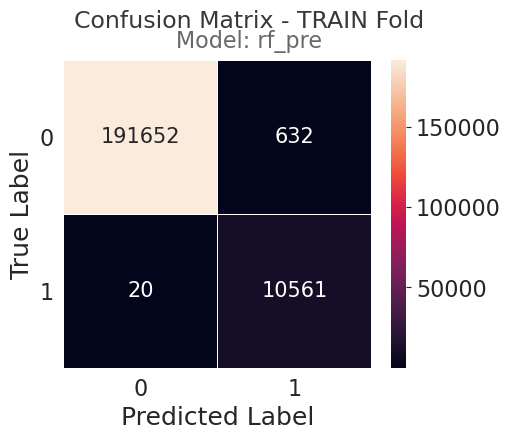

=== rf ===
RandomForestClassifier(class_weight='balanced', max_depth=30,
                       min_samples_leaf=2, n_estimators=800, n_jobs=-1,
                       random_state=42)
              precision    recall  f1-score   support

           0      1.000     0.996     0.998    192284
           1      0.940     0.998     0.968     10581

    accuracy                          0.997    202865
   macro avg      0.970     0.997     0.983    202865
weighted avg      0.997     0.997     0.997    202865



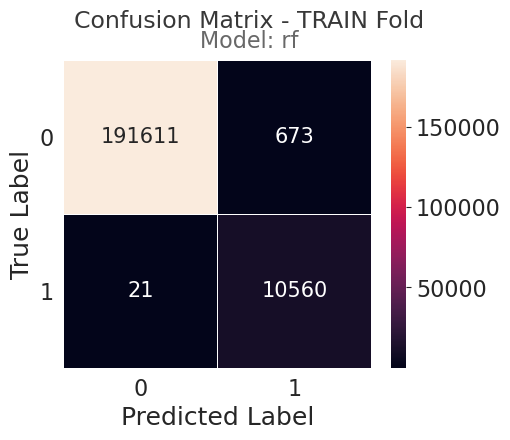

=== logit ===
LogisticRegression(C=100, max_iter=1000)
              precision    recall  f1-score   support

           0      0.951     0.996     0.973    192284
           1      0.523     0.076     0.133     10581

    accuracy                          0.948    202865
   macro avg      0.737     0.536     0.553    202865
weighted avg      0.929     0.948     0.929    202865



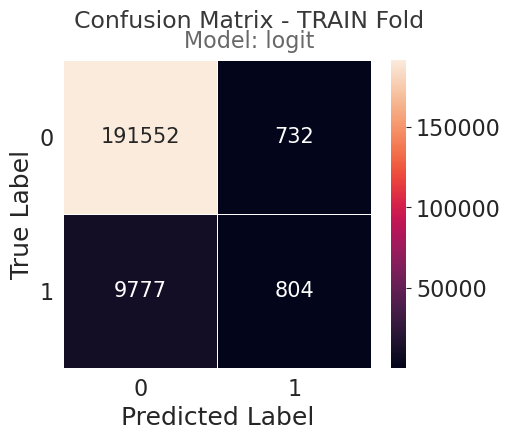

In [196]:
l_train_error = list()

for m_name, d_gs in d_search_fit.items():
    y_pred_ = d_gs.predict(X_train)
    y_true_ = y_train
    print(f"=== {m_name} ===")
    print(d_gs.best_estimator_['clf'])
#     try:
    print(classification_report(y_true_, y_pred=y_pred_, digits=3))
    accuracy_ = accuracy_score(y_true_, y_pred=y_pred_)
        
#     except ValueError:
#         y_pred_ = le.inverse_transform(y_pred_)
#         print(classification_report(y_test, y_pred=y_pred_, labels=le.classes_, digits=3))
#         accuracy_ = accuracy_score(y_test, y_pred=y_pred_)
        
    # save error dataframe
    l_train_error.append(
        {
            'model_name': m_name,
            'error': 1 - accuracy_,
            'accuracy': accuracy_,
            'model_class': str(type(d_gs.best_estimator_['clf'])).split('.')[-1][:-2],
            'model_params': str(d_gs.best_estimator_['clf']).replace('\n', ' '),
        }
    )
    
    # confusion matrix
    conf_mx = confusion_matrix(y_true=y_true_, y_pred=y_pred_, labels=le.classes_)
    mask_exclude = conf_mx == 0
    with sns.axes_style("white"):
        plt.figure(figsize=(5, 4))

        ax = sns.heatmap(
            conf_mx,
            # center=0,
            # cmap=cm.PiYG,
            xticklabels=le.classes_,
            yticklabels=le.classes_,
            annot=True,
            annot_kws={"size": 15},
            mask=mask_exclude,
            square=True,
            fmt="0.0f",
            linewidths=.5,
        )
        plt.yticks(rotation=0)
        # plt.xticks(rotation=45)
        ax.set(
            ylabel='True Label',
            xlabel='Predicted Label',
        )

        plt.figtext(
            .5, .96, f"Confusion Matrix - TRAIN Fold",
            fontsize=17, color='#383838', ha='center'
        );
        plt.figtext(
            .5, .91, f"Model: {m_name}",
            fontsize=16, color='#686868', ha='center'
        )
        plt.show()

=== rf_pre ===
              precision    recall  f1-score   support

           0      0.956     0.985     0.970     48072
           1      0.393     0.179     0.246      2645

    accuracy                          0.943     50717
   macro avg      0.674     0.582     0.608     50717
weighted avg      0.927     0.943     0.932     50717

              precision    recall  f1-score   support

           0      0.965     0.952     0.958     48072
           1      0.299     0.372     0.332      2645

    accuracy                          0.922     50717
   macro avg      0.632     0.662     0.645     50717
weighted avg      0.930     0.922     0.926     50717



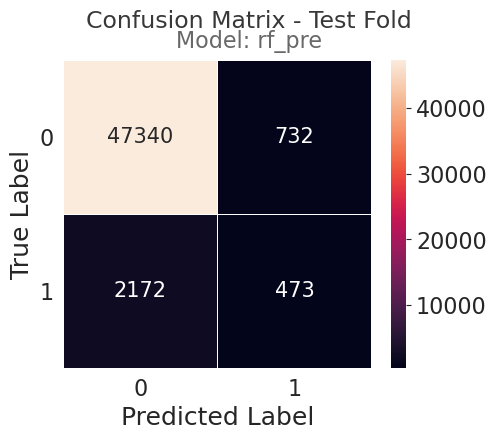

,pred-count,pred-percent,pred-pct_cumulative_sum
0,"49,512",97.6%,97.6%
1,"1,205",2.4%,100.0%


,pred_proba_0.35-count,pred_proba_0.35-percent,pred_proba_0.35-pct_cumulative_sum
0,"47,427",93.5%,93.5%
1,"3,290",6.5%,100.0%


=== rf ===
              precision    recall  f1-score   support

           0      0.956     0.985     0.970     48072
           1      0.397     0.183     0.250      2645

    accuracy                          0.943     50717
   macro avg      0.676     0.584     0.610     50717
weighted avg      0.927     0.943     0.933     50717

              precision    recall  f1-score   support

           0      0.965     0.952     0.958     48072
           1      0.299     0.374     0.332      2645

    accuracy                          0.922     50717
   macro avg      0.632     0.663     0.645     50717
weighted avg      0.930     0.922     0.926     50717



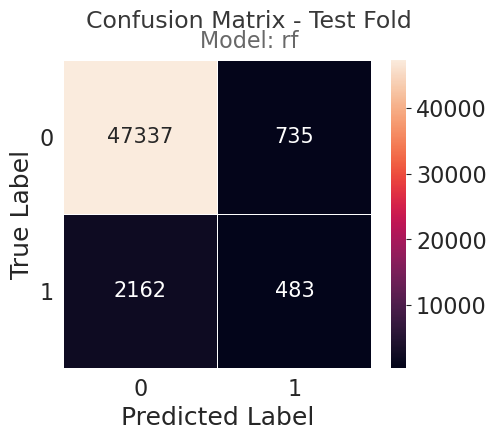

,pred-count,pred-percent,pred-pct_cumulative_sum
0,"49,499",97.6%,97.6%
1,"1,218",2.4%,100.0%


,pred_proba_0.35-count,pred_proba_0.35-percent,pred_proba_0.35-pct_cumulative_sum
0,"47,407",93.5%,93.5%
1,"3,310",6.5%,100.0%


=== logit ===
              precision    recall  f1-score   support

           0      0.952     0.996     0.974     48072
           1      0.551     0.080     0.139      2645

    accuracy                          0.949     50717
   macro avg      0.751     0.538     0.556     50717
weighted avg      0.931     0.949     0.930     50717

              precision    recall  f1-score   support

           0      0.955     0.989     0.972     48072
           1      0.444     0.157     0.232      2645

    accuracy                          0.946     50717
   macro avg      0.700     0.573     0.602     50717
weighted avg      0.929     0.946     0.933     50717



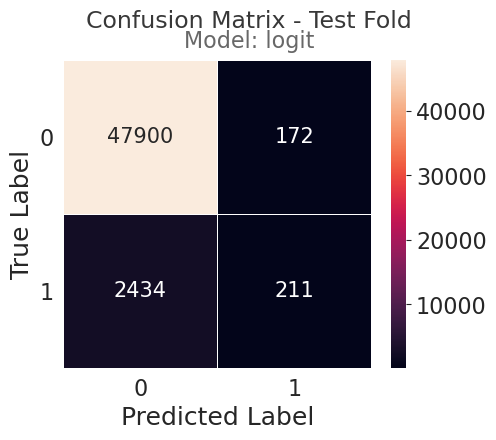

,pred-count,pred-percent,pred-pct_cumulative_sum
0,"50,334",99.2%,99.2%
1,383,0.8%,100.0%


,pred_proba_0.35-count,pred_proba_0.35-percent,pred_proba_0.35-pct_cumulative_sum
0,"49,782",98.2%,98.2%
1,935,1.8%,100.0%


In [197]:
l_test_error = list()
proba_alt_ = 0.35
for m_name, d_gs in d_search_fit.items():
    y_pred_ = d_gs.predict(X_test)
    y_pred_a = (d_gs.predict_proba(X_test)[:,1] >= proba_alt_).astype('int')
    
    print(f"=== {m_name} ===")
#     try:
    print(classification_report(y_test, y_pred=y_pred_, digits=3))
    print(classification_report(y_test, y_pred=y_pred_a, digits=3))
    accuracy_ = accuracy_score(y_test, y_pred=y_pred_)
        
#     except ValueError:
#         y_pred_ = le.inverse_transform(y_pred_)
#         print(classification_report(y_test, y_pred=y_pred_, labels=le.classes_, digits=3))
#         accuracy_ = accuracy_score(y_test, y_pred=y_pred_)
        
    # save error dataframe
    l_test_error.append(
        {
            'model_name': m_name,
            'error': 1 - accuracy_,
            'accuracy': accuracy_,
            'model_class': str(type(d_gs.best_estimator_['clf'])).split('.')[-1][:-2],
            'model_params': str(d_gs.best_estimator_['clf']).replace('\n', ' '),
        }
    )
    
    # confusion matrix
    conf_mx = confusion_matrix(y_true=y_test, y_pred=y_pred_, labels=le.classes_)
    mask_exclude = conf_mx == 0
    with sns.axes_style("white"):
        plt.figure(figsize=(5, 4))

        ax = sns.heatmap(
            conf_mx,
            # center=0,
            # cmap=cm.PiYG,
            xticklabels=le.classes_,
            yticklabels=le.classes_,
            annot=True,
            annot_kws={"size": 15},
            mask=mask_exclude,
            square=True,
            fmt="0.0f",
            linewidths=.5,
        )
        plt.yticks(rotation=0)
        # plt.xticks(rotation=45)
        ax.set(
            ylabel='True Label',
            xlabel='Predicted Label',
        )

        plt.figtext(
            .5, .96, f"Confusion Matrix - Test Fold",
            fontsize=17, color='#383838', ha='center'
        );
        plt.figtext(
            .5, .91, f"Model: {m_name}",
            fontsize=16, color='#686868', ha='center'
        )
        plt.show()
    display(
        value_counts_and_pcts(
            pd.Series(y_pred_, name='pred').to_frame(),
            'pred',
        )
    )
    display(
        value_counts_and_pcts(
            pd.Series(y_pred_a, name=f'pred_proba_{proba_alt_}').to_frame(),
            f'pred_proba_{proba_alt_}',
        )
    )

# Check proba outputs

In [198]:
d_search_fit['rf_pre'].best_estimator_['clf']

RandomForestClassifier(class_weight='balanced', max_depth=30,
                       min_samples_leaf=2, n_estimators=800, n_jobs=-1,
                       random_state=42)


=== rf_pre ===


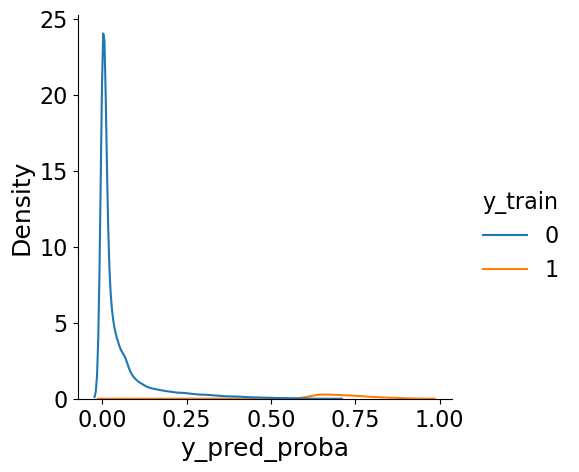

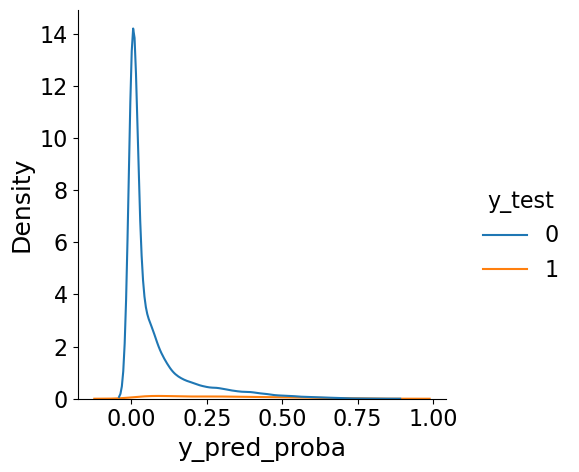


=== rf ===


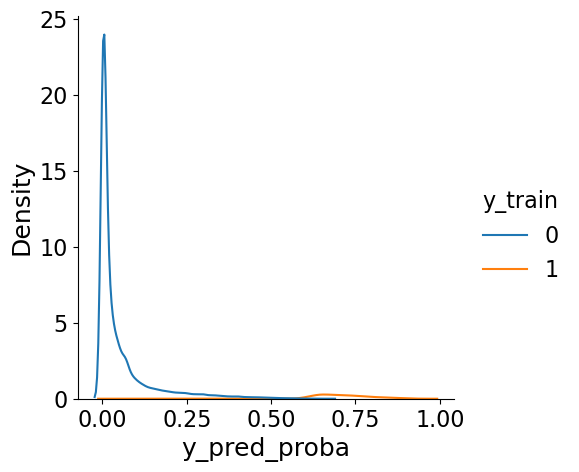

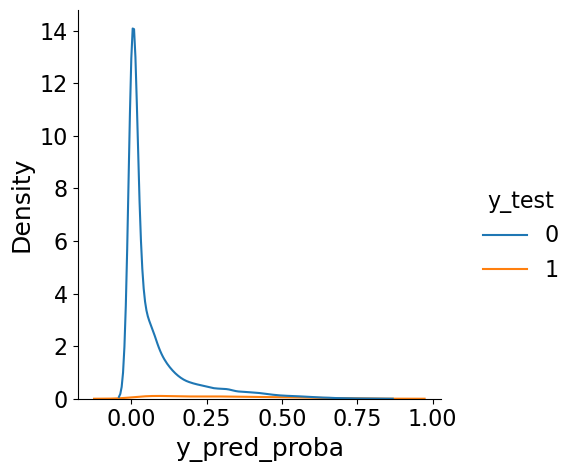


=== logit ===


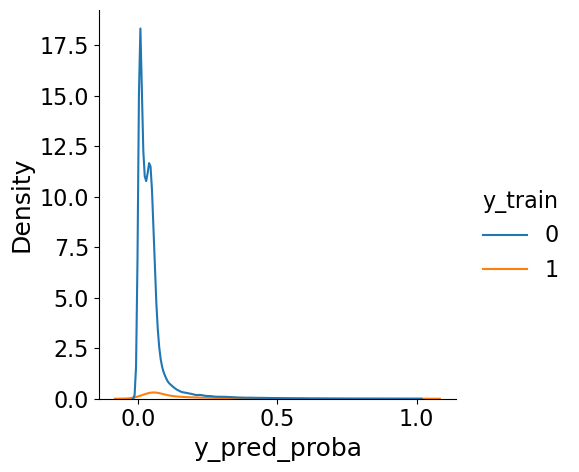

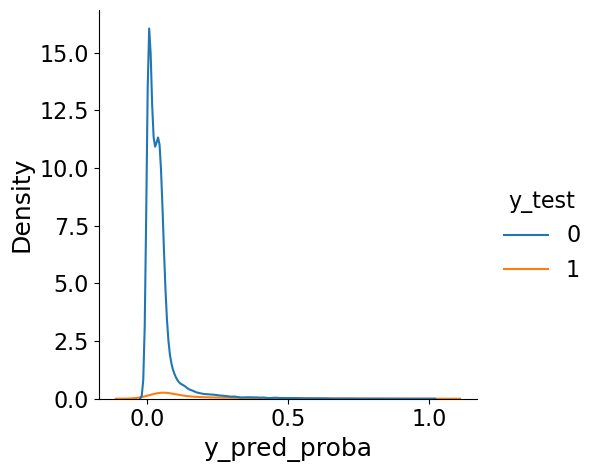

In [199]:
for m_name, d_gs in d_search_fit.items():
    print(f"\n=== {m_name} ===")
    df_y_test_ = pd.DataFrame(
        {
            'y_test': y_test,
            'y_pred_proba': d_gs.predict_proba(X_test)[:, 1],
        }
    )
    df_y_train_ = pd.DataFrame(
        {
            'y_train': y_train,
            'y_pred_proba': d_gs.predict_proba(X_train)[:, 1],
        }
    )
    sns.displot(data=df_y_train_, x="y_pred_proba", kind='kde', hue='y_train')
    plt.show()
    
    sns.displot(data=df_y_test_, x="y_pred_proba", kind='kde', hue='y_test')
    plt.show()

# Get feature importance
Might help us better select which columns to use for additional stratification

In [204]:
# d_gs.best_estimator_['preprocess'].transformers_

In [201]:
d_gs.best_estimator_['preprocess'].transformers_[0]

('onehot', OneHotEncoder(), ['legacy_user_cohort'])

In [202]:
d_gs.best_estimator_['preprocess'].transformers_[0][1].get_feature_names()

array(['x0__missing_', 'x0_casual', 'x0_core', 'x0_new', 'x0_resurrected'],
      dtype=object)

## Impurity based importance
Note that these may not be the best approach when we have features with high cardinality


=== rf_pre ====
(25, 3)


,feature_names,importances,std
7,user_clicks_pn_t7,0.223636,0.095628
8,user_clicks_trnd_t7,0.114592,0.084654
6,user_receives_pn_t7,0.084882,0.013593
24,cosine_similarity,0.054902,0.012303
9,screen_view_count_14d,0.051839,0.049904
11,num_post_consumes_home,0.051785,0.016763
17,pct_post_consumes_nsfw,0.045190,0.007192
12,num_post_consumes_community,0.044527,0.008509
10,num_post_consumes,0.044325,0.009560
5,tos_sub_count,0.043805,0.009733


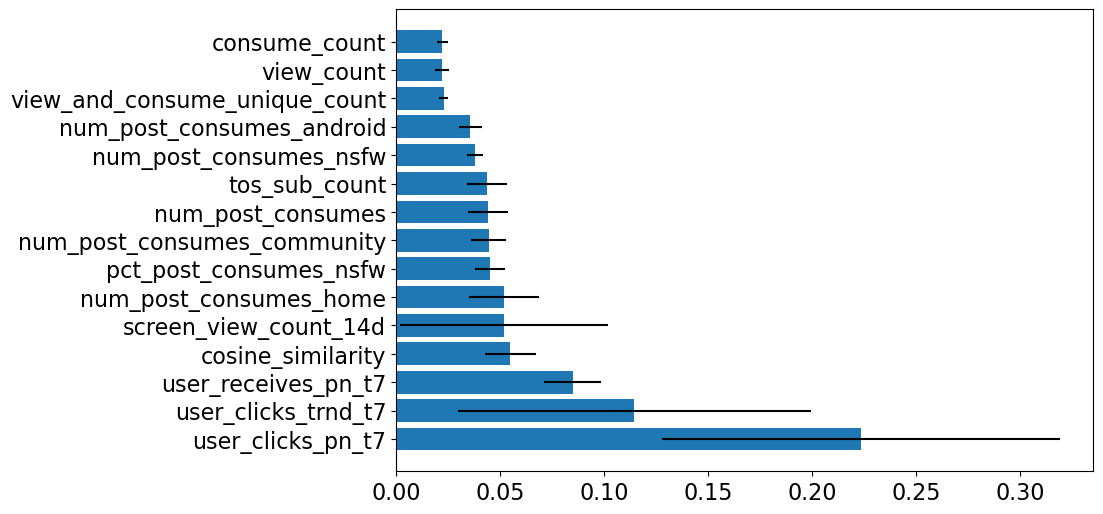


=== rf ====
(25, 3)


,feature_names,importances,std
7,user_clicks_pn_t7,0.221821,0.096255
8,user_clicks_trnd_t7,0.115946,0.084415
6,user_receives_pn_t7,0.084801,0.013686
24,cosine_similarity,0.054887,0.012475
9,screen_view_count_14d,0.052624,0.050141
11,num_post_consumes_home,0.051520,0.016543
17,pct_post_consumes_nsfw,0.045011,0.007603
12,num_post_consumes_community,0.044619,0.008610
10,num_post_consumes,0.044191,0.009456
5,tos_sub_count,0.043832,0.009761


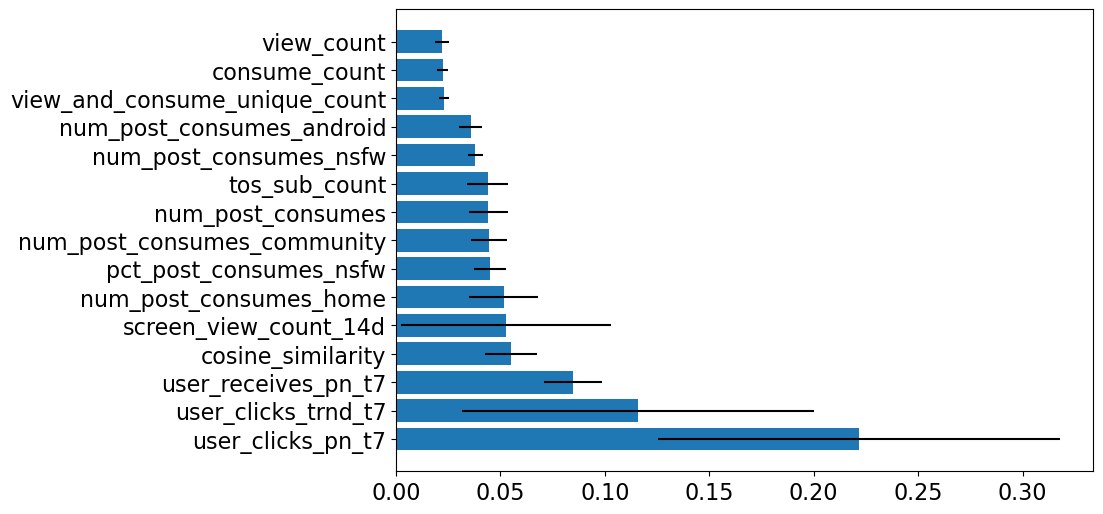

In [205]:
for m_name, d_gs in d_search_fit.items():
    try:
        df_importances = (
            pd.DataFrame(
                {
                    'feature_names': (
                        # assumes that one-hot encoding is first in ALL preprocessing pipelines
                        list(d_gs.best_estimator_['preprocess'].transformers_[0][1].get_feature_names()) +
                        l_train_cols_num
                    ),
                    'importances': d_gs.best_estimator_['clf'].feature_importances_,
                    'std': np.std([tree.feature_importances_ for tree in d_gs.best_estimator_['clf'].estimators_], axis=0),
                }
            )
            .sort_values(by=['importances'], ascending=False)
        )
        print(f"\n=== {m_name} ====")
        print(df_importances.shape)
        display(df_importances.head(10))
        
        plt.barh(
            y=df_importances.head(15)['feature_names'],
            width=df_importances.head(15)['importances'],
            xerr=df_importances.head(15)['std'],
        )
        plt.show()
    except Exception as e:
        pass

In [ ]:
# ax = sns.barplot(
#     data=df_importances.head(15),
#     x='importances',
#     y='feature_names',
# )

In [ ]:

# plt.barh(
#     y=df_importances.head(15)['feature_names'],
#     width=df_importances.head(15)['importances'],
#     xerr=df_importances.head(15)['std'],
# )

## Importance based on feature permutation
This is EXPENSIVE because we need to shuffle features AND refit a model N times.

In [206]:
from sklearn.inspection import permutation_importance

In [207]:
%%time

perm_importance = permutation_importance(
    d_search_fit['rf'].best_estimator_,
    X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1
)

CPU times: user 40.4 s, sys: 35.8 s, total: 1min 16s
Wall time: 1min 25s


In [ ]:
list(d_search_fit['rf'].best_estimator_['preprocess'].transformers_[0][1].get_feature_names())

In [213]:
len(l_train_cols_num)

20

In [214]:
df_importances_p = (
    pd.DataFrame(
        {
            'feature_names': (
                # assumes that one-hot encoding is first in ALL preprocessing pipelines
                # list(d_search_fit['rf'].best_estimator_['preprocess'].transformers_[0][1].get_feature_names()) +
                l_train_cols_cat +
                l_train_cols_num
            ),
            'importances': perm_importance.importances_mean,
            'std': perm_importance.importances_std,
        }
    )
    .sort_values(by=['importances'], ascending=False)
)
print(df_importances_p.shape)
df_importances_p.head(10)

(21, 3)


,feature_names,importances,std
9,num_post_consumes_post_detail,0.000140,0.000098
18,consume_ios_count,-0.000335,0.000213
10,num_post_consumes_ios,-0.000690,0.000239
3,user_clicks_pn_t7,-0.000737,0.000287
16,view_count,-0.001244,0.000230
2,user_receives_pn_t7,-0.001284,0.000233
19,consume_android_count,-0.001483,0.000295
20,cosine_similarity,-0.001497,0.000272
0,legacy_user_cohort,-0.001711,0.000415
14,view_and_consume_unique_count,-0.001838,0.000300


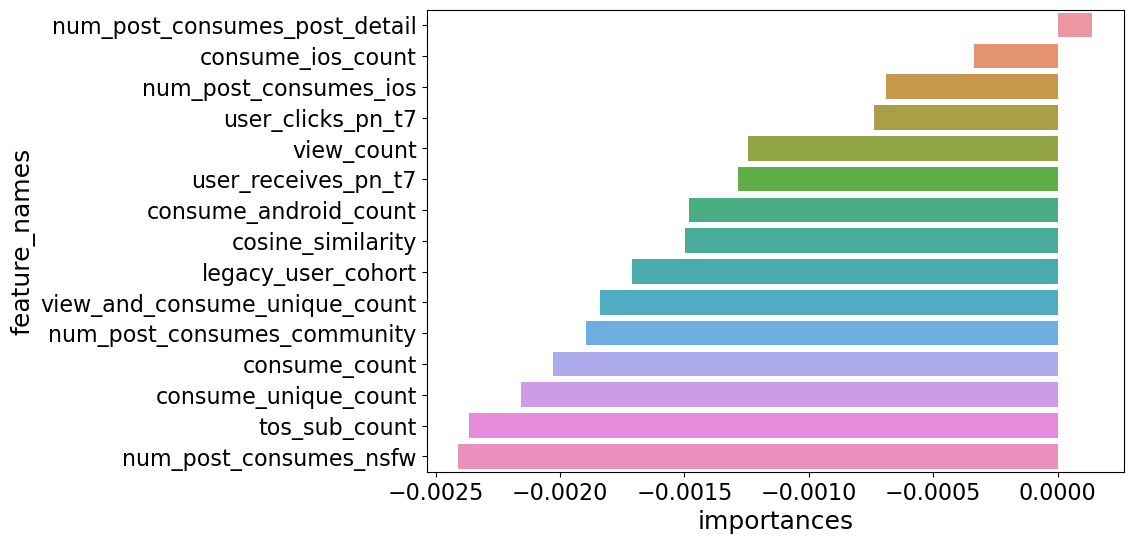

In [215]:
ax = sns.barplot(
    data=df_importances_p.head(15),
    x='importances',
    y='feature_names',
)

<BarContainer object of 15 artists>

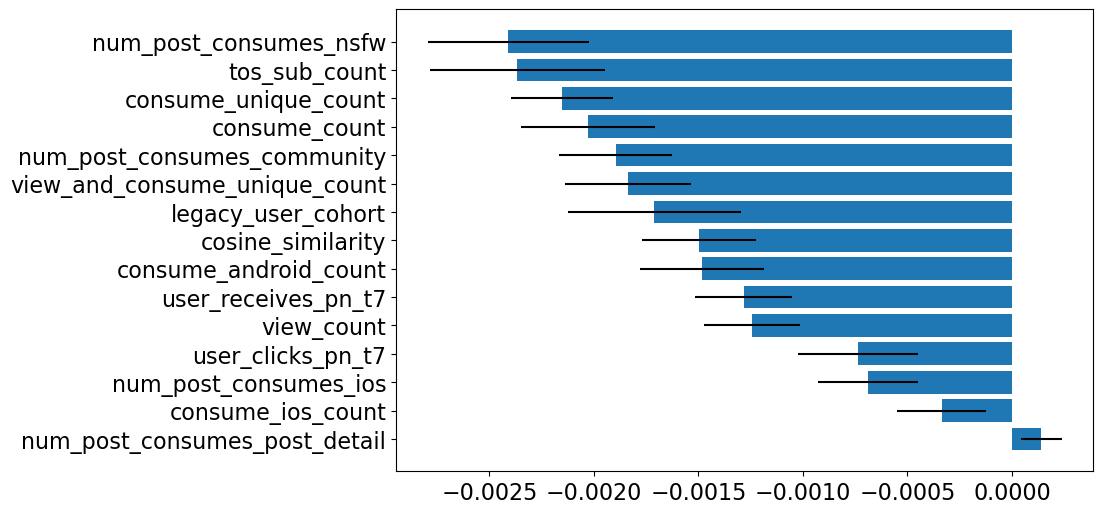

In [210]:

plt.barh(
    y=df_importances_p.head(15)['feature_names'],
    width=df_importances_p.head(15)['importances'],
    xerr=df_importances_p.head(15)['std'],
)

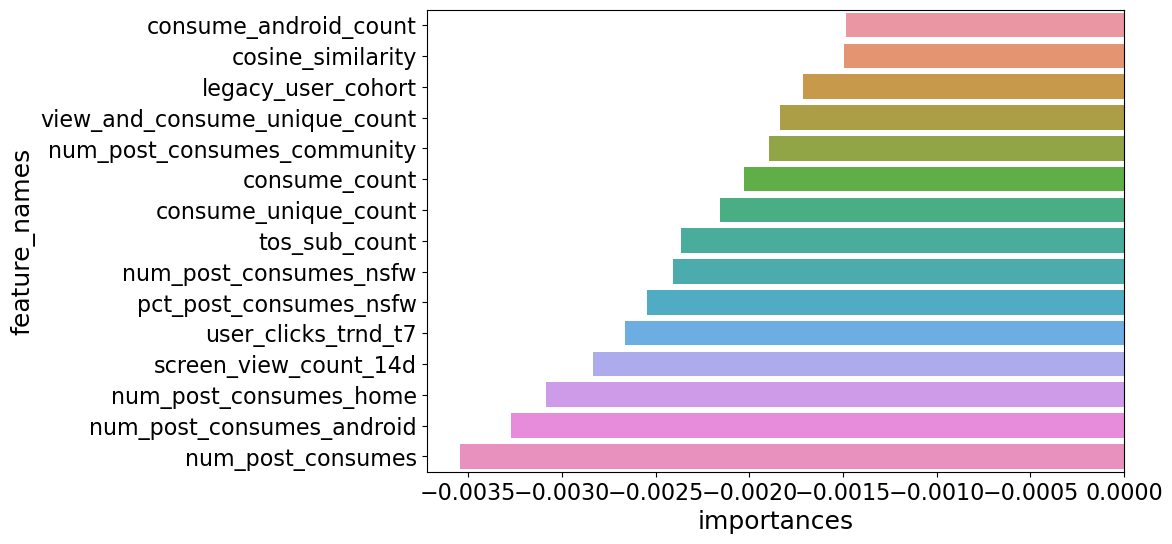

In [211]:
ax = sns.barplot(
    data=df_importances_p.tail(15),
    x='importances',
    y='feature_names',
)

In [212]:
df_importances_p.tail(10)

,feature_names,importances,std
17,consume_count,-0.002029,0.000321
15,consume_unique_count,-0.002155,0.000244
1,tos_sub_count,-0.002366,0.000419
12,num_post_consumes_nsfw,-0.002409,0.000386
13,pct_post_consumes_nsfw,-0.002545,0.000204
4,user_clicks_trnd_t7,-0.002664,0.000109
5,screen_view_count_14d,-0.002831,0.000393
7,num_post_consumes_home,-0.003086,0.000343
11,num_post_consumes_android,-0.003269,0.000217
6,num_post_consumes,-0.003545,0.000335
